<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Import-Libraries-&amp;-Load-Data" data-toc-modified-id="Import-Libraries-&amp;-Load-Data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Import Libraries &amp; Load Data</a></span><ul class="toc-item"><li><span><a href="#Import-Libraries" data-toc-modified-id="Import-Libraries-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Import Libraries</a></span></li><li><span><a href="#Self-Defined-Tools" data-toc-modified-id="Self-Defined-Tools-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Self-Defined Tools</a></span></li><li><span><a href="#Load-Data" data-toc-modified-id="Load-Data-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Load Data</a></span></li><li><span><a href="#Data-Merge" data-toc-modified-id="Data-Merge-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Data Merge</a></span></li></ul></li><li><span><a href="#Analysis-of-variable-and-label" data-toc-modified-id="Analysis-of-variable-and-label-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Analysis of variable and label</a></span><ul class="toc-item"><li><span><a href="#train-and-test-distributions" data-toc-modified-id="train-and-test-distributions-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>train and test distributions</a></span></li></ul></li><li><span><a href="#Conclusion" data-toc-modified-id="Conclusion-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Conclusion</a></span></li></ul></div>

# Import Libraries & Load Data
##  Import Libraries

In [1]:
import numpy as np
import pandas as pd
import os 
from tqdm import tqdm_notebook
from sklearn.preprocessing import StandardScaler
from sklearn.svm import NuSVR, SVR
from sklearn.metrics import mean_absolute_error
import lightgbm as lgb
import xgboost as xgb
import time
import datetime 
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedKFold
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
import gc

from scipy.signal import hilbert
from scipy.signal import hann
from scipy.signal import convolve
from scipy import stats
from sklearn.kernel_ridge import KernelRidge
 
from collections import Counter 
from statistics import mode 
    
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

from tqdm import tqdm
import json 
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold
from itertools import product
import ast 
tqdm.pandas()

import plotly.plotly as py
import plotly
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
plotly.offline.init_notebook_mode(connected=True)

## Self-Defined Tools 

In [2]:
def value_counts_plot(df, name, xmin = False):
    
    plt.figure(figsize=[16,8])
    plt.subplot(1, 2, 1)
    df[name].value_counts().sort_index().plot()
    if xmin == True:
        plt.xlim(xmin = -100)
    plt.xlabel(name)
    plt.ylabel('Number of appeareance')
    
    plt.subplot(1, 2, 2)
    df[name].value_counts().value_counts().sort_index().plot()
    if xmin == True:
        plt.xlim(xmin = -100)
    plt.xlabel('Number of appeareance of {}'.format(name))
    plt.ylabel('Number of appeareance of appearance')

## Load Data

In [3]:
path = '/data/Data_JieZhang/KDD/Phase2/'

train_queries1 = pd.read_csv(path + 'train_queries_phase1.csv', parse_dates=['req_time'])
train_plans1   = pd.read_csv(path + 'train_plans_phase1.csv', parse_dates=['plan_time'])
train_clicks1  = pd.read_csv(path + 'train_clicks_phase1.csv')

train_queries2 = pd.read_csv(path + 'train_queries_phase2.csv', parse_dates=['req_time'])
train_plans2   = pd.read_csv(path + 'train_plans_phase2.csv', parse_dates=['plan_time'])
train_clicks2  = pd.read_csv(path + 'train_clicks_phase2.csv')

profiles      = pd.read_csv(path + 'profiles.csv') 

test_queries  = pd.read_csv(path + 'test_queries.csv', parse_dates=['req_time'])
test_plans    = pd.read_csv(path + 'test_plans.csv', parse_dates=['plan_time'])

In [4]:
train_plans   = pd.concat([train_plans1, train_plans2],axis=0,ignore_index=True)
train_queries = pd.concat([train_queries1, train_queries2],axis=0,ignore_index=True)
train_clicks  = pd.concat([train_clicks1, train_clicks2],axis=0,ignore_index=True)

## Data Merge

In [5]:
train = train_queries.merge(train_plans, 'left', ['sid'])
test  = test_queries.merge(test_plans, 'left', ['sid']) 
train = train.merge(train_clicks, 'left', ['sid'])
train['click_mode'] = train['click_mode'].fillna(0).astype(int) 

# Analysis of variable and label

In [6]:
train.head()

,sid,pid,req_time,o,d,plan_time,plans,click_time,click_mode
0,419087,22813.0,2018-10-17 10:17:11,"116.34,39.99","116.37,39.86",2018-10-17 10:17:11,"[{""distance"": 17883, ""price"": 700, ""eta"": 3561...",2018-10-17 10:17:27,7
1,481938,NaN,2018-10-13 15:50:15,"116.43,39.94","116.46,39.95",2018-10-13 15:50:15,"[{""distance"": 3358, ""price"": 200, ""eta"": 1742,...",2018-10-13 15:50:21,1
2,441201,34393.0,2018-10-13 16:15:21,"116.28,40.01","116.39,39.99",2018-10-13 16:15:21,"[{""distance"": 14638, ""price"": 700, ""eta"": 3452...",2018-10-13 16:15:40,7
3,347266,NaN,2018-10-22 13:26:04,"116.31,39.51","116.32,39.72",2018-10-22 13:26:04,"[{""distance"": 26407, ""price"": 900, ""eta"": 3992...",2018-10-22 13:26:10,7
4,206269,NaN,2018-11-08 10:27:23,"116.33,39.89","116.59,39.76",2018-11-08 10:27:23,"[{""distance"": 42000, ""price"": 800, ""eta"": 6941...",2018-11-08 10:27:30,7


## train and test distributions
1. the train and test samples are different

In [14]:
train['dt']   = pd.to_datetime(train['req_time']).dt.date
test['dt']    = pd.to_datetime(test['req_time']).dt.date  
data = pd.concat([train, test], ignore_index=True)

Text(0.5,0,'date')

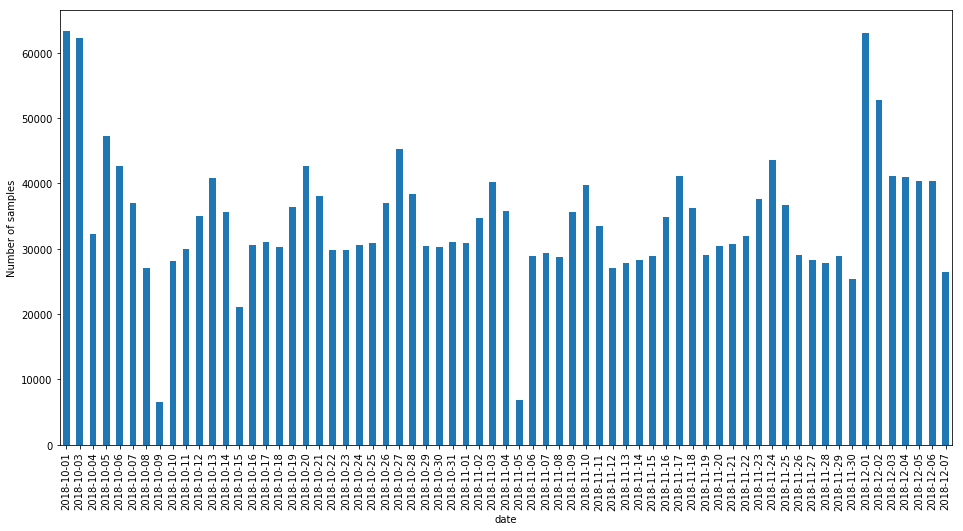

In [11]:
plt.figure(figsize=[16,8])  
data['dt'].value_counts().sort_index().plot(kind = 'bar')
plt.ylabel('Number of samples')
plt.xlabel('date')    

In [40]:
from datetime import timedelta 
rk = pd.DataFrame()
times = []
rank_mean = []
data['pct'] = 0
for i in range(5):
    st = pd.datetime(2018,12,8)- timedelta(7 * (i+1))
    en = pd.datetime(2018,12,8)  - timedelta(7 * i)
     
    index = (data['req_time'] > st ) & (data['req_time'] <= en) # 
    
    sum_  = np.sum(index)
    data.loc[index, 'pct'] = 1 / sum_

In [38]:
st

datetime.datetime(2018, 11, 2, 0, 0)

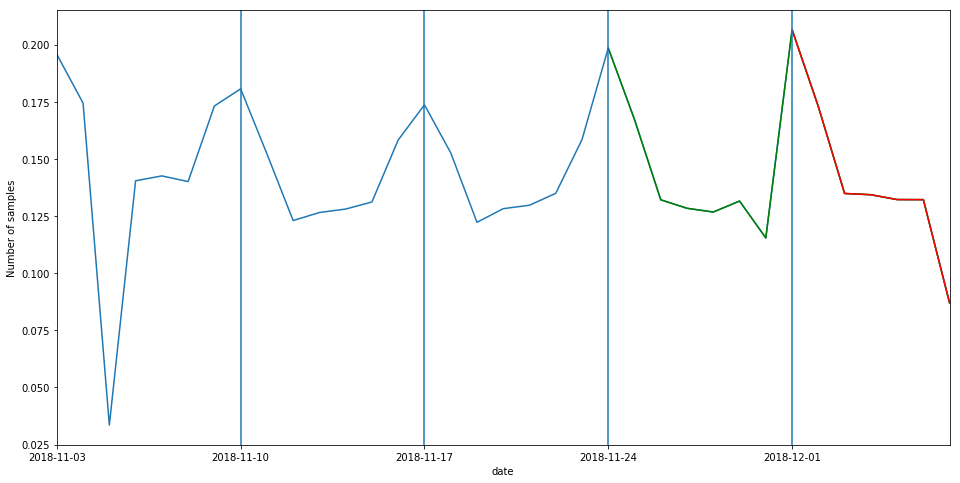

In [43]:
plt.figure(figsize=[16,8])  
data.loc[data['req_time'] >= st].groupby('dt')['pct'].sum().plot()
data.loc[data['req_time'] >= pd.datetime(2018,11,24)].groupby('dt')['pct'].sum().plot(color='green')
data.loc[data['req_time'] >= pd.datetime(2018,12,1)].groupby('dt')['pct'].sum().plot(color='red')
plt.axvline(x=pd.datetime(2018,12,1))
plt.axvline(x=pd.datetime(2018,11,24))
plt.axvline(x=pd.datetime(2018,11,17))
plt.axvline(x=pd.datetime(2018,11,10))
# plt.xticks()
# (x=0.22058956) #plt.axvline(st,hold=None,label="1",color='black',linestyle="--")
plt.ylabel('Number of samples')
plt.xlabel('date')    
plt.axvline(x=0.33088437)
plt.axvline(x=2.20589566) 

# Conclusion
This notebook mainly do analysis on the distribution of training and test data.